<a href="https://colab.research.google.com/github/AngelGuadarrama/Consulta_DENUE/blob/main/extractor_denue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import pandas as pd
import csv
from os import listdir
import re
from ipywidgets import interact, interact_manual
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Extractor del Directorio Estadístico Nacional de Unidades Económicas (INEGI)

El objetivo es generar un programa, una base de datos o tabular, que le permita encontrar clientes para alianzas potenciales.

In [15]:
def capital(texto):
  words=texto.split(sep=' ')
  texto_cap=[word.capitalize() for word in words]
  resultado= " ".join(texto_cap)
  return resultado


def acentos(texto=""):
  words=texto.split(sep=' ')
  words=[re.sub(r"á", "a", word) for word in words]
  words=[re.sub(r"é", "e", word) for word in words]
  words=[re.sub(r"í", "i", word) for word in words]
  words=[re.sub(r"ó", "o", word) for word in words]
  words=[re.sub(r"ú", "u", word) for word in words]
  
  resultado= " ".join(words)
  
  return resultado



## Extractor y limpieza


*  Archivo compendio_total_contactable.txt (con |) (carpeta de lectura y escritura)

*  Mensaje con tamaño, nombre de columnas y columnas faltantes

*  Filtrar por telefono/correo, compendio_total_contactable.txt

* Quitar acentos, multiespacios y usar Capital()

In [17]:
@interact_manual
def compendio_total(dir_int='/content/drive/MyDrive/Colab Notebooks/Extractor_DENUE/', dir_out='/content/drive/MyDrive/Colab Notebooks/Extractor_DENUE/'):
  global columnas_compendio
  
  csv_files=[file for file in listdir(dir_int) if file[-3:] == 'csv' and file[:5] == 'denue']
  #csv_files=["denue_inegi_16_.csv","denue_inegi_17_.csv","denue_inegi_13_.csv"]

  with open(dir_out+'compendio_total_contactable.txt', "w") as my_output_file: #Archivo txt
    columnas_compendio=[]

    for csv_file in csv_files: 
        print('Cargando archivo: '+csv_file)
        i=0 #Numero de filas (archivo inicial)
        j=0#Numero de filas (archivo limpio)

        with open(dir_int+csv_file, "r", encoding = "ISO-8859-1") as my_input_file: #Abre un archivo csv

            for row in csv.reader(my_input_file):

                if  i==0: #Encabezado
                   row.append('Ruta_Origen')
                   columnas=row
                   print('  Columnas: ', columnas)

                   if csv_files.index(csv_file) == 0: #Si es el primer archivo se agregan las columnas
                     columnas_compendio=columnas
                   else:
                     column_extra=list(set(columnas).difference(set(columnas_compendio)))
                     column_faltante=list(set(columnas_compendio).difference(set(columnas)))
                     #print('')
                     print('Este archivo no contiene la(s) columna(s): ', column_extra)
                     print('Este archivo contiene ademas la(s) columna(s): ', column_faltante)
                     columnas_compendio+= column_extra

                   my_output_file.write("|".join(row)+'\n') #Separador y salto de linea

                else:
                   row.append(csv_file) #Ruta_Origen
                   
                   telefono= len( re.findall(r"\d{10}", row[columnas_compendio.index('telefono')]) ) != 0
                   correo= len( re.findall(r"@", row[columnas_compendio.index('correoelec')]) ) != 0

                   if i==1: print('  Primera Fila: ',row)

                   if telefono or correo:
                      row=[ capital(acentos( re.sub(r"\s+", " ",col ).lower() ) ) for col in row]
                      my_output_file.write("|".join(row)+'\n') #Separador y salto de linea
                      if j==1: print('  Primera Fila Limpia: ',row)
                      j+=1
                   
      
                i+=1  

        print('  Total de filas (archivo inicial): '+str(i)) 
        print('  Total de filas (archivo contactable): '+str(j)) 
        print('  Total de columnas: '+str(len(row)))  
        print('')
        print('')
    my_output_file.close()



  print('  Se ha creado el archivo compendio_total.txt exitosamente!')
  

interactive(children=(Text(value='/content/drive/MyDrive/Colab Notebooks/Extractor_DENUE/', description='dir_i…

## Analisis de Negocio

El objetivo es hacer un análisis de la base de datos contactable, para enunciar al área de negocio los giros principales por entidad federativa.

*	Descriptivo crudo de todos los registros que contenga la palabra Banco o cualquier otra palabra clave para un negocio

El descriptivo debe enunciar al menos nombre de actividad y personal ocupado.
¿Qué otras variables puedes ser reelevantes?

Otras variables relevantes podrian ser raz_soc, tipo_vial y la entidad

In [36]:
with open('/content/drive/MyDrive/Colab Notebooks/Extractor_DENUE/compendio_total_contactable.txt', "r") as file_clean:
    lines= file_clean.readlines()
    j=1
    actividades=[]
    establecimientos=[]
    for line in lines:
        row=line.split(sep="|")
        banco= len( re.findall(r"Banco", row[columnas_compendio.index('nom_estab')]) ) != 0
        if banco and j <50 :
          print(j)
          print('Nombre:', row[columnas_compendio.index('nom_estab')])
          print('Actividad: ', row[columnas_compendio.index('nombre_act')])
          print('Ocupacion: ', row[columnas_compendio.index('per_ocu')])
          print('')
          j+=1

          actividades.append(row[columnas_compendio.index('nombre_act')])
          establecimientos.append(row[columnas_compendio.index('nom_estab')])
        

1
Nombre: Banco De Alimentos Sin Nombre
Actividad:  Comercio Al Por Menor En Tiendas De Abarrotes, Ultramarinos Y Miscelaneas
Ocupacion:  0 A 5 Personas

2
Nombre: Farmacia Bancomext
Actividad:  Farmacias Sin Minisuper
Ocupacion:  0 A 5 Personas

3
Nombre: Biblioteca Del Banco De Mexico
Actividad:  Bibliotecas Y Archivos Del Sector Publico
Ocupacion:  6 A 10 Personas

4
Nombre: Accendo Banco
Actividad:  Banca Multiple
Ocupacion:  101 A 250 Personas

5
Nombre: Accendo Banco
Actividad:  Banca Multiple
Ocupacion:  101 A 250 Personas

6
Nombre: Actinver Banco
Actividad:  Asesoria En Inversiones
Ocupacion:  6 A 10 Personas

7
Nombre: Actinver Banco Fondos De Inversion
Actividad:  Otros Servicios Relacionados Con La Intermediacion Bursatil
Ocupacion:  0 A 5 Personas

8
Nombre: Banco Actinver, S.a., Institucion De Banca Multiple, Grupo Financiero Actinver
Actividad:  Banca Multiple
Ocupacion:  251 Y Mas Personas

9
Nombre: Banco Azteca Sa Institucion De Banca Multiple
Actividad:  Banca Multip

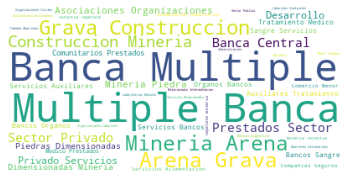

In [20]:
actividades_unicas = []
[actividades_unicas.append(x) for x in actividades if x not in actividades_unicas]

stop_words_sp = set(stopwords.words('spanish'))

cloud=WordCloud(background_color='white', stopwords= stop_words_sp, random_state=2).generate(' '.join(actividades))
plt.imshow(cloud)
plt.axis('off')
plt.show()


In [21]:
print('Numero de Actividades unicas: ', len(actividades_unicas))
actividades_unicas

Numero de Actividades unicas:  45


['Comercio Al Por Menor En Tiendas De Abarrotes, Ultramarinos Y Miscelaneas',
 'Farmacias Sin Minisuper',
 'Bibliotecas Y Archivos Del Sector Publico',
 'Banca Multiple',
 'Asesoria En Inversiones',
 'Otros Servicios Relacionados Con La Intermediacion Bursatil',
 'Banca Central',
 'Servicios Relacionados Con La Intermediacion Crediticia No Bursatil',
 'Banca De Desarrollo',
 'Compañias De Seguros',
 'Casas De Bolsa',
 'Corporativos',
 'Suministro De Personal Permanente',
 'Servicios De Administracion De Negocios',
 'Servicios De Emergencia Comunitarios Prestados Por El Sector Privado',
 'Servicios De Alimentacion Comunitarios Prestados Por El Sector Privado',
 'Servicios De Bancos De Organos, Bancos De Sangre Y Otros Servicios Auxiliares Al Tratamiento Medico Prestados Por El Sector Publico',
 'Cafeterias, Fuentes De Sodas, Neverias, Refresquerias Y Similares',
 'Asociaciones Y Organizaciones Civiles',
 'Asociaciones, Organizaciones Y Camaras De Productores, Comerciantes Y Prestadores 


Suponiendo que no tuvieramos el apoyo del campo de nombre de actividad, sería importante observar que sí sabemos de nuestros datos, por su contenido:

*  Hacer una nube de bi-palabras y un Ngram (2 o 3) para entender que tipo de servicios se van a promover por estado (todos) usando solo el nombre del establecimiento

* En el ejemplo no se ha hecho limpieza ¿Qué tipo de limpiezas se pueden hacer?  (ngram, count)

In [22]:
vect= CountVectorizer(max_features=50, 
                      stop_words=stop_words_sp, 
                      ngram_range=(2,3))

X=vect.fit_transform(pd.Series(establecimientos)) 
top_50_bi_tri_grams=pd.DataFrame(X.toarray(), columns=vect.get_feature_names())

In [23]:
top_50_bi_tri_grams.sum().sort_values(ascending=False)

banco inbursa                 330
banco compartamos             143
inbursa walmart                78
banco inbursa walmart          78
banco inbursa sanborns         61
inbursa sanborns               61
banco bajio                    37
inbursa sams                   35
banco inbursa sams             35
banco wal                      28
wal mart                       27
banco wal mart                 27
institucion banca              26
banca multiple                 26
mart mexico                    25
mexico adelante                25
institucion banca multiple     25
wal mart mexico                24
mart mexico adelante           24
inbursa plaza                  20
banco inbursa plaza            20
banco inbursa bodega           19
bodega aurrera                 19
inbursa bodega                 19
inbursa bodega aurrera         19
banco forjadores               17
banco mexico                   17
bbva bancomer                  15
compartamos banco              15
banco arena   